In [12]:
import tensorflow as tf
import sys
sys.path.append('../lib')
from table_detection import TableNet, Pipeline, TableMask, ColumnMaskProcessor
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
from utils import *
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from table_detection import TableMask

In [5]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('models/2020_09_24')
model.load_weights(latest)

In [6]:
class Evaluator:
    def __init__(self,gt_mask,predicted_mask):
        self.gt_mask = gt_mask
        self.predicted_mask = predicted_mask
        
    def iou(self):
        intersection = np.logical_and(self.gt_mask,self.predicted_mask).sum()
        union = np.logical_or(self.gt_mask,self.predicted_mask).sum()
        return intersection/union

In [7]:
def select_image(folder):
    return os.path.join(folder,np.random.choice(os.listdir(folder),1)[0])

In [8]:
scores=[]
table_mask_dir = '../results/test_table_mask'
image_dir = '../results/test_image/'
images = [x.split('/')[-1].split('.')[0] for x in os.listdir(image_dir)]

for table_id in tqdm.tqdm(images):
    pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(os.path.join(image_dir,table_id+'.nutrition.jpg')))))
    pipeline.run(0.8)
    pipeline.get_predicted_table_mask()
    pred_mask = pipeline.predicted_table_mask
    gt_mask = cv2.imread(os.path.join('../data/test/table_mask/',table_id+'.nutrition.jpeg'))
    evaluator = Evaluator(gt_mask,pred_mask)
    scores.append(evaluator.iou())
    
print('score: {}'.format(sum(scores)/len(images)))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:18<00:00,  1.61s/it]

score: 0.7553472276355427


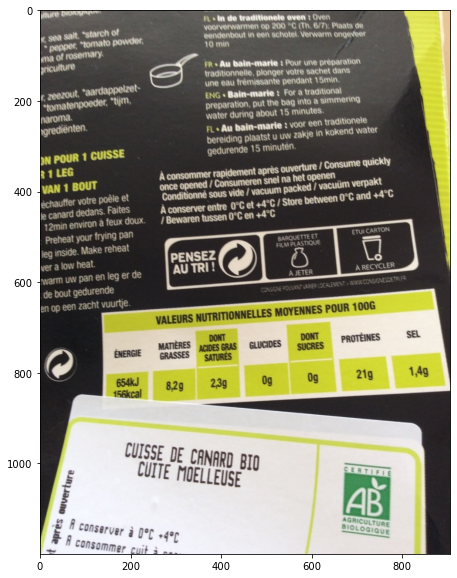

In [19]:
random_image= select_image('../../openfoodfacts-ai/nutrition-table-extraction/notebooks/data/image_files')
plt.figure(figsize=(20,10))
plt.imshow(plt.imread(random_image))

In [10]:
pipeline = Pipeline(model,tf.image.decode_jpeg((tf.io.read_file(random_image))))

In [16]:
pipeline.run(0.7)
column_mask_processor = ColumnMaskProcessor(pipeline.images[-1],pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8'))
column_mask_processor.process_mask()
column_mask_processor.get_peaks(30,25)
column_mask_processor.find_column_areas()

../lib\table_detection.py:260: RuntimeWarning: divide by zero encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:260: RuntimeWarning: invalid value encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:272: RuntimeWarning: divide by zero encountered in true_divide
  div = np.float32(self.column_mask)/(close)
../lib\table_detection.py:272: RuntimeWarning: invalid value encountered in true_divide
  div = np.float32(self.column_mask)/(close)


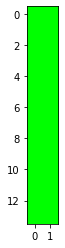

In [17]:
pipeline.tm_list[-1].draw_bounding_box()
plt.imshow(pipeline.tm_list[-1].image_with_bounding_box)

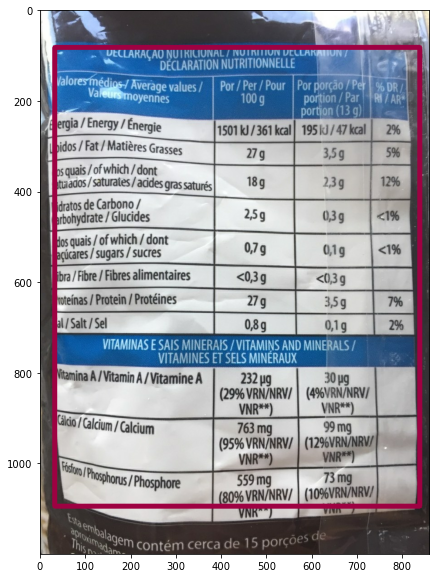

In [792]:
import matplotlib.cm as cm
colors = iter(cm.Spectral(np.linspace(0,1,len(pipeline.tm_list))))
original_image = pipeline.tm_list[0].image.copy()
bbx = pipeline.tm_list[0].original_bounding_box
x,y,w,h = bbx
color = tuple(next(colors)*255)[:-1]
cv2.rectangle(original_image,(x,y),(x+w,y+h),color,10)

for i in range(1,len(pipeline.tm_list)):
    bbx = get_absolute_coordinates(bbx,pipeline.tm_list[i].original_bounding_box)
    x,y,w,h = bbx
    color = tuple(next(colors)*255)[:-1]
    cv2.rectangle(original_image,(x,y),(x+w,y+h),color,10)
    
plt.figure(figsize=(20,10))
plt.imshow(original_image)

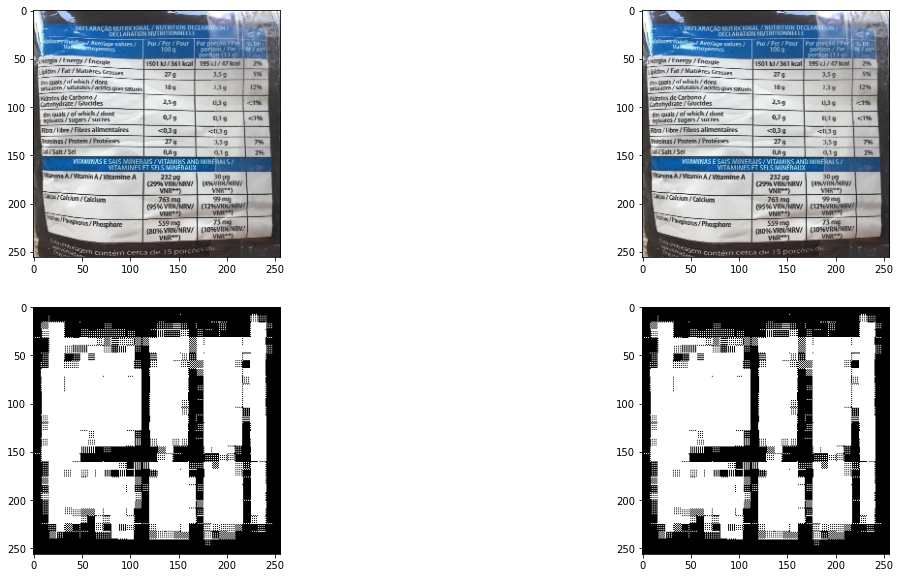

In [793]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.resize(pipeline.images[0].numpy(),(256,256)))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.resize(pipeline.tm_list[-1].image,(256,256)))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(pipeline.predicted_column_masks[0],cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(pipeline.predicted_column_masks[-1],cmap='gray')

C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


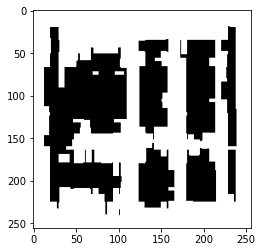

In [794]:
column_mask = pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8')
#column_mask = np.logical_and(pipeline.predicted_column_masks[-1].numpy().reshape(256,256).astype('uint8'),pipeline.predicted_table_masks[-1].numpy().reshape(256,256).astype('uint8'))
mask = np.zeros((column_mask.shape),np.uint8)
# Définir le pas du kernal >20 pour que les lignes verticales soient plus accentuées 

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,2))
close = cv2.morphologyEx(column_mask,cv2.MORPH_CLOSE,kernel1)
div = np.float32(column_mask)/(close)

kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(5,2))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

close = np.logical_or(close,column_mask).astype('uint8')

kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,10))
close = cv2.morphologyEx(column_mask,cv2.MORPH_OPEN,kernel1)
div = np.float32(column_mask)/(close)


kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(1,5))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)

kernely = cv2.getStructuringElement(cv2.MORPH_RECT,(5,2))
#plt.imshow(dx,cmap='gray')
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close = cv2.morphologyEx(close,cv2.MORPH_DILATE,kernely,iterations = 1)
plt.imshow(close,cmap='gray')

close_sum = close.sum(axis=1)
indexes = np.where(close_sum>close_sum.max()*0.8)[0]

Text(0.5, 1.0, 'Vertical Edges')

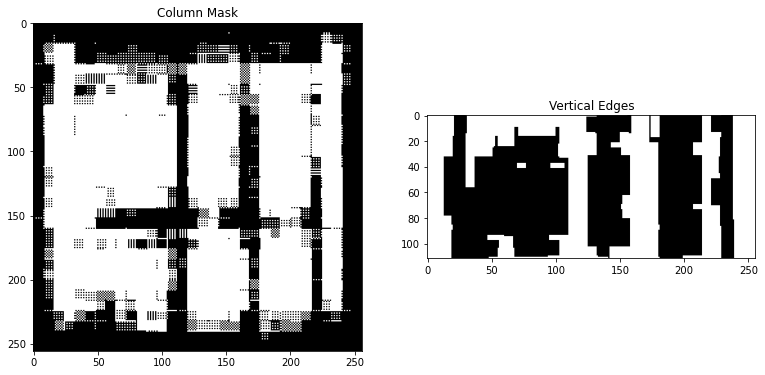

In [798]:
plt.figure(figsize=(20,30))
plt.subplot(131),plt.imshow(column_mask,cmap = 'gray')
plt.title('Column Mask')
plt.subplot(132),plt.imshow(sub_mask,cmap = 'gray')
plt.title('Vertical Edges')

In [800]:
#close[np.where(close_sum<close_sum.max()//3)]

In [801]:
#close_sum = close.sum(axis=0)
#close[:,np.where(close_sum>close_sum.max()*0.8)] = 0
#close = close.reshape(close.shape[0],close.shape[-1])

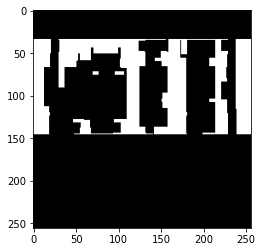

In [802]:
plt.imshow(close,cmap='gray')

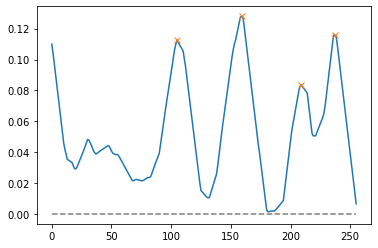

In [804]:
size = column_mask.shape
width = size[0]
window_size=20


#Initialize input image = output of edges

normalizer = Normalizer()
vertical_sum = sub_mask.sum(axis=0)
#vertical_sum_mv_avg = moving_average(vertical_sum,n=window_size)
vertical_sum_mv_avg = runningMean(vertical_sum,window_size)
vertical_sum_mv_avg_nm = normalizer.fit_transform([vertical_sum_mv_avg])[0]
np.insert(vertical_sum_mv_avg_nm, 0,0)
np.insert(vertical_sum_mv_avg_nm,-1,0)
#= vertical_sum_mv_avg_nm[-1] = 0

peaks, _ = find_peaks(vertical_sum_mv_avg_nm, prominence=vertical_sum_mv_avg_nm.std(), distance=25)
plt.plot(vertical_sum_mv_avg_nm)
plt.plot(peaks, vertical_sum_mv_avg_nm[peaks], "x")
plt.plot(np.zeros_like(vertical_sum_mv_avg_nm), "--", color="gray")
plt.show()

In [827]:
image = cv2.resize(pipeline.tm_list[-1].image,(256,256))
corrected_peaks = [peak+(window_size//2) for peak in peaks]
for i,peak in enumerate(corrected_peaks):
    cv2.line(image, pt1=(peak,0), pt2=(peak,256), color=(255,0,0), thickness=2)

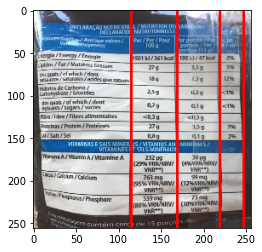

In [828]:
plt.imshow(image)

In [829]:
image = pipeline.tm_list[-1].image.copy()
original_peaks = [x*pipeline.tm_list[-1].image.shape[1]//256 for x in corrected_peaks]
for i,peak in enumerate(original_peaks):
    cv2.line(image, pt1=(peak,0), pt2=(peak,image.shape[0]), color=(255,0,0), thickness=5)

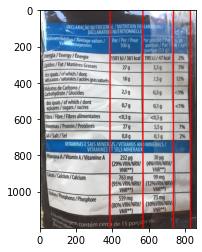

In [830]:
plt.imshow(image)

C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sadok.guermazi\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


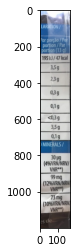

In [872]:
plt.imshow(column_mask_processor.column_areas[1])

In [851]:
column_mask_processor.peaks

[386, 567, 735, 829]

In [486]:
pipeline.tm_list[-1].draw_bounding_box()

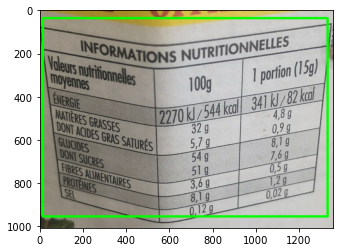

In [487]:
plt.imshow(pipeline.tm_list[-1].image_with_bounding_box)

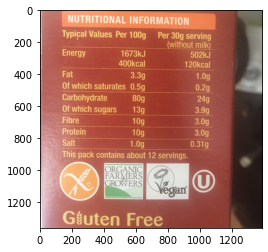

In [345]:
plt.imshow(tf.image.decode_jpeg((tf.io.read_file('../results/test_image/0058449771890.nutrition.jpg'))))

In [37]:
pipeline.predict()
pipeline.process_prediction()
print(pipeline.is_predicted_area_sufficient())

1/1 [==============================] - 0s 75ms/sample
False


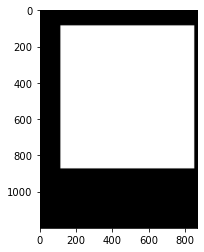

In [14]:
plt.imshow(pipeline.tm.corrected_mask)

Wall time: 945 ms


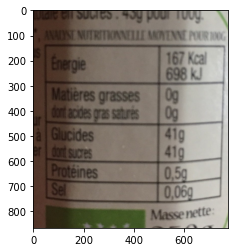

In [27]:
%%time
table_mask_dir = '../results/table_mask/'
image_dir= '../results/image/'
image_name = '09356566.nutrition.jpg'
image = plt.imread(os.path.join(image_dir,image_name))
predicted_mask = cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(table_mask_dir,image_name)),(256,256)),cv2.COLOR_BGR2GRAY)

tm = TableMask(image.copy(),predicted_mask.copy())
tm.get_bounding_box_coordinates()
tm.generate_corrected_mask()
tm.get_bounding_box_coordinates_on_original_image()
tm.draw_bounding_box()
plt.imshow(tm.get_cropped_image())

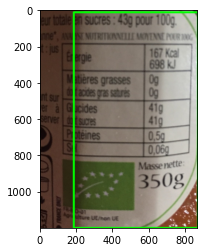

In [29]:
plt.imshow(tm.,cmap='gray')

In [17]:
plt.imshow(cv2.cvtColor(np.uint8(255*pipeline.predicted_table_mask.numpy()).reshape(256,256), cv2.COLOR_BGR2RGB))

error: C:\ci\opencv_1512688052760\work\modules\imgproc\src\color.cpp:11016: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


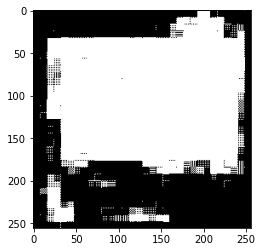

In [24]:
plt.imshow(np.repeat(255*pipeline.predicted_table_mask.numpy(),3).reshape(256,256,3))

In [ ]:
plt.imread()

In [11]:
bw_mask = np.repeat(255*np.uint8(pipeline.predicted_table_mask.numpy()),3).reshape(256,256,3)

In [13]:
blur = (cv2.GaussianBlur(bw_mask,(5,5),0))
img_bw = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
binarized = 1*(bw_mask<100)
coef = get_coef(binarized)
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (process_number(coef*60),process_number(coef*60)))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (process_number(coef*20),process_number(coef*20)))
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
mask = np.dstack([mask, mask, mask]) // 255
out = bw_mask* mask
cleaned_out = (255*(cv2.cvtColor(out.astype('uint8'), cv2.COLOR_BGR2GRAY) >0)).astype('uint8')
cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#cv2.drawContours(img, contours, -1, (0,255,0), 3)
c = max(cnts, key=cv2.contourArea)
rect = cv2.boundingRect(c)
x,y,w,h = rect

In [14]:
x,y,w,h

(15, 1, 234, 192)

In [223]:
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

In [216]:
mask = np.dstack([mask, mask, mask]) // 255

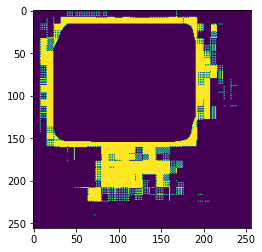

In [220]:
plt.imshow(cleaned_out)

In [98]:
cv2.cvtColor(a,cv2.COLOR_RGB2GRAY)

error: C:\ci\opencv_1512688052760\work\modules\imgproc\src\color.cpp:11010: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cv::cvtColor
